# Parsing textual data - Survey for French presidential elections 2nd round

**Introduction : ** 
This is the second notebook exploring my own dataset from a survey I carried out. Instead of looking at just numbers, which I could just as easily find from official polls, I wanted some open-ended responses. This contains richer information that can be played with. 

**Summary: **

I focus on using IBM Watson to translate from French into English and then parse the emotional content of open-ended survey responses. We find that **responses that mention Marine Le Pen seem to raise the meter for fear compared to those that mention Emmanuel Macron.** 

Nonetheless, please view this notebook as more of a 'playground' with Watson than a true scientific exploration of 'emotions' and 'tones', as upon analyzing the output of the API, it is clear that there is much room for improvement. 

The Part I notebook explores the question of where first round votes for neither Macron nor Le Pen were likely to go to. 

#### Steps:
1) Translate all open-ended responses with **IBM LanguageTranslator**. 
- *Why LanguageTranslate?: *I do not read French, and got tired of copying and pasting into Google Translate, even though I learnt a few words this way.

2)  **Prepare the data** 

- For ease of analysis and more reliability, I decided to extract all the open-ended responses into one list variable regardless of question posed, 
- and focus the responses that mentioned Le Pen and those that mentioned Macron. 

3) Analyze the textual data with **IBM ToneAnalyzer**, 
- This gives us a rating on 5 emotions on the scale of {0,1}. 
- *Why ToneAnalyzer?:* It's a simple way of analyzing all 1014 responses with IBM Watson. Voters vote on emotion too

4) Acknowledging the non-normality of these emotion metrics, I apply the **Kolmogorov-Smirnov test** to 
- compare Le Pen and Macron on the distributions of these five emotions, and 
- plot their cumulative distribution functions as a visual check.  



##### Ideas for further analysis: 

- Multiply each response into more data by stripping into seperate sentences and attaching the voting intention as a binary outcome (e.g. 1 Macron, 0 Le Pen). 

- Read sample responses that are off the charts for fear. Try to get a sense for what is driving this 'fear' in the Watson API.

- Split data into Le Pen supporter vs Macron supporter.

- Re-do survey design such that all open-ended answers are compulsory, at the cost of survey respondents dropping out. 

- Extract connotations for other words with word2vec. 

----------------

## Imports

In [1]:
import pandas as pd 
pd.set_option('display.max_columns', 300)
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline
import json 
from watson_developer_cloud import ToneAnalyzerV3
from watson_developer_cloud import LanguageTranslatorV2

# Reading Data into DataFrame with pandas 

In [2]:
dff=pd.read_csv("../data/survey2_cleaned.csv", encoding="utf-8", \
                index_col=[0],low_memory=False,infer_datetime_format=True)

In [3]:
dff.head()

,ID,ID collecteur,Date de début,Date de fin,Q1,Q3,Q4,Q4-text,Q5,Q5-text,Q6,Q6-text,Q7,Q8,Q9,Q10,Q11,Q12
0,6189761401,156443487,2017-05-09 23:01:30,2017-05-09 23:04:21,Non,Macron,Non,NaN,Cela dépend du candidat,NaN,Emmanuel Macron,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6185182074,156443487,2017-05-06 22:07:12,2017-05-06 22:09:50,Oui,Le Pen,Oui,NaN,Pas sûr,NaN,Marine Le Pen,NaN,Le Pen,On verra,Non,Oui,Oui,Oui
2,6185012445,156443487,2017-05-06 16:36:46,2017-05-06 16:45:08,Oui,Le Pen,Oui,NaN,Très sûr,NaN,Marine Le Pen,NaN,Macron,Une élection majoritairement d'opposition à un...,Oui,Une colère et un râle bol général des conditio...,Non,La radicalité n'est pas une solution en soit ...
3,6184748911,156443487,2017-05-06 09:03:49,2017-05-06 09:11:30,Non,Melenchon,Non,NaN,Autre (veuillez préciser),Je ne me suis pas inscrit,Blanc,Je n'apprécie ni lun ni l'autre,NaN,NaN,NaN,NaN,NaN,NaN
4,6184653695,156443487,2017-05-06 04:46:44,2017-05-06 04:54:53,Oui,Fillon,Oui,NaN,Très sûr,NaN,Emmanuel Macron,NaN,Macron,La France n'est pas prête d'accueillir une fem...,Oui,NaN,Non,Je pense que les 2 candidats n'aideront pas la...


In [4]:
dff=dff.fillna("")

# Translator 

In [5]:
import getpass
print("conversation username:")
username = getpass.getpass()

print("conversation password:")
password = getpass.getpass()

#do not run this as I have already saved the output in the data/ folder

conversation username:
········
conversation password:
········


In [6]:
language_translator = LanguageTranslatorV2(
    username=username,
    password=password)


# Survey data with Translator

In [7]:
def translatee(x):
    if x == "":
        return ""
    else:    
        return language_translator.translate(x, source='fr',
                                  target='en')
   

In [9]:
teststring=dff["Q12"][dff["Q12"]!=""]
teststring=teststring[0:100]
teststring.head()
translatee(teststring[4])

'I think the 2 candidates will not France. Today we vote between the plague and cholera. Dur 1 choice but the values of France must continue ... between other fraternity and it is not the FN defends it'

In [10]:
dff['Q8-en'] = dff['Q8'].apply(lambda x : translatee(x))
dff['Q10-en'] = dff['Q10'].apply(lambda x : translatee(x))
dff['Q12-en'] = dff['Q12'].apply(lambda x : translatee(x))
dff['Q4-en'] = dff['Q4-text'].apply(lambda x : translatee(x))
dff['Q5-en'] = dff['Q5-text'].apply(lambda x : translatee(x))
dff['Q6-en'] = dff['Q6-text'].apply(lambda x : translatee(x))

In [11]:
dff.shape

(1014, 24)

In [12]:
print(dff['Q10-en'].unique()[:20])

['' 'Yes'
 'An anger and a rattle bowl general living conditions contributes to a trend necessarily radicalized.'
 'They are all agree, they want to have a hope that a failure ' 'Macron'
 'My friends also believe that Emanuel Macron will remportet this election because it would appear that in the media is the most candidate supported.'
 'The same thing as me'
 'For the same reason that I think Navy will elected.' 'They agree with me'
 'Macron said lies. Moreover it needs a atrium to answer questions'
 'It think macron will be elected ' 'Pck its for the pen'
 'Quite simply for the same reason as me. '
 'Too afraid of big change for France '
 'Because we all have the same point of view '
 'They saw that between LePen and Macron, one candidate was for the French people '
 'My friends are people who voted Melancon like me, for them, Le Pen is racism and Macron a rich, or it is better to someone who likes money to power rather than someone who is not human'
 'Because they think this and tha

The translations are not the best. Sometimes, they are partially translated. Emmanuel Macron will "remportet" this election, according to one answer. Remporter means to win in French. And sometimes they are translated too fully. Marine le Pen is translated to "Navy":

In [14]:
matching =[s for s in list(dff['Q8-en'][dff["Q8-en"]!=""]) if 'Navy' in s]
matching = matching = matching +  [s for s in list(dff['Q10-en'][dff["Q10-en"]!=""]) if 'Navy' in s]
matching = matching +  [s for s in list(dff['Q12-en'][dff["Q12-en"]!=""]) if 'Navy' in s]
matching = matching +  [s for s in list(dff['Q4-en'][dff["Q4-en"]!=""]) if 'Navy' in s]
matching = matching +  [s for s in list(dff['Q5-en'][dff["Q5-en"]!=""]) if 'Navy' in s]
matching = matching +  [s for s in list(dff['Q6-en'][dff["Q6-en"]!=""]) if 'Navy' in s]
print("There are %s responses that refer to Marine le Pen as 'Navy'! For example:" % len(matching))
print(matching[1:5])

There are 44 responses that refer to Marine le Pen as 'Navy'! For example:
['Because simply Macron was Hollande regime therefore same shit again for 5 years he is the author of the 49: 3 of the Act El komhri. Navy n is not qlqs just racist qlqs who wants to defend the history of his country and continue as a write a story Française ', 'More convincing on projects that Navy The debate pen', 'Only Navy Lepen can save France.', 'Navy always desired to deal with French and his country first before going to his nose elsewhere that the silk is financial problem school housing ext but for us French priority. Because it is our right we have but we get nothing for Gard other while some French sleep outside in the cold to eat a piece of bread back to Franc and an excellent idea to take our product loco to me our cost promote our product our land has the place to buy foreign wholesaler ']


But the meaning is clear in many other instances and is enough for our present purposes. 

#### Save this file to csv so we do not have to run Translator again in the future. 

In [15]:
dff.to_csv('../data/survey2_translated.csv', sep=',', encoding='utf-8')

#### Then I strip out all text responses from all respondents into one large corpus, like a 'bag of sentences'. 

(Alternatively, I can analyze the open-ended responses by voting intention and by question, which will take a significantly more time with less reliability in the results due to smaller sample size of only 400 per question. )

Start by reading the file saved from before (if loading this from another computer or another time):

In [16]:
dff=pd.read_csv("../data/survey2_translated.csv", encoding="utf-8", low_memory=False,\
                 index_col=[0],infer_datetime_format=True)
dff=dff.fillna("") #fast method for now, could use more sophistication 
dff.head()


,ID,ID collecteur,Date de début,Date de fin,Q1,Q3,Q4,Q4-text,Q5,Q5-text,Q6,Q6-text,Q7,Q8,Q9,Q10,Q11,Q12,Q8-en,Q10-en,Q12-en,Q4-en,Q5-en,Q6-en
0,6189761401,156443487,2017-05-09 23:01:30,2017-05-09 23:04:21,Non,Macron,Non,,Cela dépend du candidat,,Emmanuel Macron,,,,,,,,,,,,,
1,6185182074,156443487,2017-05-06 22:07:12,2017-05-06 22:09:50,Oui,Le Pen,Oui,,Pas sûr,,Marine Le Pen,,Le Pen,On verra,Non,Oui,Oui,Oui,It will,Yes,Yes,,,
2,6185012445,156443487,2017-05-06 16:36:46,2017-05-06 16:45:08,Oui,Le Pen,Oui,,Très sûr,,Marine Le Pen,,Macron,Une élection majoritairement d'opposition à un...,Oui,Une colère et un râle bol général des conditio...,Non,La radicalité n'est pas une solution en soit ...,A majority of opposition to an election party ...,An anger and a rattle bowl general living cond...,The radicalism is not a solution for long term...,,,
3,6184748911,156443487,2017-05-06 09:03:49,2017-05-06 09:11:30,Non,Melenchon,Non,,Autre (veuillez préciser),Je ne me suis pas inscrit,Blanc,Je n'apprécie ni lun ni l'autre,,,,,,,,,,,I am not registered,I appreciate nor sun nor the other
4,6184653695,156443487,2017-05-06 04:46:44,2017-05-06 04:54:53,Oui,Fillon,Oui,,Très sûr,,Emmanuel Macron,,Macron,La France n'est pas prête d'accueillir une fem...,Oui,,Non,Je pense que les 2 candidats n'aideront pas la...,France is not ready to host a woman in power a...,,I think the 2 candidates will not France. Toda...,,,


Then I rip all the translations into a new list. 

In [17]:
list_en=['Q4-en','Q5-en','Q6-en','Q8-en','Q10-en','Q12-en']

alltext = []
    
for question in list_en: 
        print(question)
        alltext = alltext + list(dff[question][dff[question]!=""]) 

Q4-en
Q5-en
Q6-en
Q8-en
Q10-en
Q12-en


Taking a look at what we've got here! 

In [18]:
import random 
random.sample(alltext, 10)

["I don't know too ",
 'Button because I think navy lepen Is bad view by many French citizens ',
 'Le Pen because it has to move France that France is not to seek advice to Europe ',
 'My friends think me such ',
 'I have not the right to vote',
 "Or I don't know abstention",
 'He agreed with me, but are not but vote that will change the thing ',
 'I think so that it is the right choice in any case it will be better than Macron and will make a good choice for France.',
 'Even answer that question 11.',
 'Macron']

In [19]:
print("The above is just a sampling of %s total responses." %len(alltext))

The above is just a sampling of 1584 total responses.


# Tone Analyzer

In [20]:
import getpass
print("conversation username:")
username = getpass.getpass()

print("conversation password:")
password = getpass.getpass()

#do not run this as I have already saved the output in the data/ folder

conversation username:
········
conversation password:
········


In [21]:
tone_analyzer = ToneAnalyzerV3(
   username=username,
   password=password,
   version='2016-05-19')

def parse_toneanalyzer_response(json_data):
    """Parses the JSON response from ToneAnalyzer to return
    a dictionary of emotions and their corresponding score.

    Parameters
    ----------
    json_data: {dict} a json response from ToneAnalyzer (see Notes)

    Returns
    -------
    dict : a {dict} whose keys are emotion ids and values are their corresponding score.

    Notes
    -----
    for an example of json see type pytest_data/tones_1.json
    """
    emotions = {}
    for entry in json_data['document_tone']['tone_categories']:
        if entry['category_id'] == 'emotion_tone':
            for emotion in entry['tones']:
                emotion_key = emotion['tone_name']
                emotion_value = emotion['score']
                emotions[emotion_key] = emotion_value
    return(emotions)

"France is not ready to host a woman in power" has 40% joy and 40% disgust - an interesting mix. The emphasis for 'joy' may come from "France" and "woman", instead of "not ready". 

In [22]:
json_response = tone_analyzer.tone(text="France is not ready to host a woman in power")
print(parse_toneanalyzer_response(json_response))
json_response['document_tone']['tone_categories']

{'Anger': 0.04737, 'Disgust': 0.389663, 'Fear': 0.030071, 'Joy': 0.397983, 'Sadness': 0.205372}


[{'category_id': 'emotion_tone',
  'category_name': 'Emotion Tone',
  'tones': [{'score': 0.04737, 'tone_id': 'anger', 'tone_name': 'Anger'},
   {'score': 0.389663, 'tone_id': 'disgust', 'tone_name': 'Disgust'},
   {'score': 0.030071, 'tone_id': 'fear', 'tone_name': 'Fear'},
   {'score': 0.397983, 'tone_id': 'joy', 'tone_name': 'Joy'},
   {'score': 0.205372, 'tone_id': 'sadness', 'tone_name': 'Sadness'}]},
 {'category_id': 'language_tone',
  'category_name': 'Language Tone',
  'tones': [{'score': 0.0, 'tone_id': 'analytical', 'tone_name': 'Analytical'},
   {'score': 0.0, 'tone_id': 'confident', 'tone_name': 'Confident'},
   {'score': 0.0, 'tone_id': 'tentative', 'tone_name': 'Tentative'}]},
 {'category_id': 'social_tone',
  'category_name': 'Social Tone',
  'tones': [{'score': 0.165197,
    'tone_id': 'openness_big5',
    'tone_name': 'Openness'},
   {'score': 0.487946,
    'tone_id': 'conscientiousness_big5',
    'tone_name': 'Conscientiousness'},
   {'score': 0.87161,
    'tone_id': 

You can see that ToneAnalyzer gives us three types of "Tones": Emotion Tone, Language Tone, and Social Tone. We are going to extract just emotion_tone using the function parse_toneanalyzer_response() defined in the earlier cell.


Further, understand the limitations for the Tone Analyzer - finding 'tone' where there is none, as I show below. This poses a problem. ** There is no notion of statistical significance for these 'emotions'.** Since we are just 'playing' with the API here, we take our results with a grain of salt. 



In [23]:
json_response = tone_analyzer.tone(text="testing one two three")
print(parse_toneanalyzer_response(json_response))

{'Anger': 0.208284, 'Disgust': 0.048741, 'Fear': 0.274484, 'Joy': 0.162929, 'Sadness': 0.165661}


Next, I extract the responses that refer to either Marine le Pen or Macron by name into new lists `lepen` and `macron`. 

In [24]:
lepen_token = ['Navy','Marine','Pen']
lepen = []

for token in lepen_token: 
    lepen = lepen + [s for s in list(alltext) if token in s]
        
lepen = set(lepen)
print("There are %s responses that refer to Marine le Pen. For example:" % len(lepen))
print(random.sample(lepen,5))


There are 239 responses that refer to Marine le Pen. For example:
['I think it is Emanuel Macron who will win this election because Navy Lepen represents the national front and that it is the daughter of Jean-Marie Lepen former candidate whose ideas laid too far and a "fear" of the national front is established ', 'Not the Pen is saying that its will be worse', 'They think vote Le Pen is to be racist ', 'Yes Marine Le Pen is my good choice, because it is a strong woman who think about his country ', 'Marine pen already because we cetait and appercu macron is a con then if with all the crap that balance it even on him and roof is that the press finds it is elected president bravo to the French people submitted ']


In [25]:
macron_token = ['macron','emmanuel','emanuel',"Marcrin"]
macron = []

for token in macron_token: 
    macron = macron + [s for s in list(alltext) if token in s]
        
macron=set(macron)
print("There are %s responses that refer to Emmanuel Macron. For example:" % len(macron))
print(random.sample(macron,5))


There are 113 responses that refer to Emmanuel Macron. For example:
['He want to vote the pen because it think macron is 2nd holland but I think it croivent that the pen will leave the French well-functioning', 'Because macron has a good program ', 'I think c macron that will win the election because Madam pen not merit and almost all the people imigré want to do lol)', 'I am neither for or pen macron', 'My friend pence mele thing because the macron will not help us because it will fuck any and we will in the shit']


# Parsing Emotional Data out of Selected Responses 

Then, I set up a DataFrame (`lepen_parsed` and `macron_parsed`), with a column containing each response that mentions either subject. These DataFrames will eventually store the emotion tone ratings.

I then set up a dictionary that will hold the emotion tone ratings with `parse_toneanalyzer_response()`.

In [26]:
lepen_parsed = pd.DataFrame()
lepen_parsed["text"]=list(lepen)
lepen_parsed

lepen_dict = {}

for index, row in lepen_parsed.iterrows(): 
    response = tone_analyzer.tone(text=row["text"])
    lepen_dict[row[0]]=parse_toneanalyzer_response(response)
#check the index is ok

In [27]:
len(lepen_dict.items())

239

Then I extract the emotion ratings into the DataFrame. 

In [28]:
emotions =['joy', 'anger', 'fear', 'sadness', 'disgust']

In [29]:
for emote in emotions:
    lepen_parsed[emote] = lepen_parsed['text'].map(lambda x : lepen_dict[x].get(emote.title(),0.0))

In [30]:
lepen_parsed.describe()
#lepen_parsed.head()

,joy,anger,fear,sadness,disgust
count,239.000000,239.000000,239.000000,239.000000,239.000000
mean,0.265535,0.198189,0.220312,0.225838,0.125129
std,0.203124,0.147702,0.228768,0.157149,0.120666
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.087012,0.093048,0.078977,0.108020,0.042467
50%,0.225105,0.159921,0.139709,0.185714,0.081719
75%,0.407288,0.256494,0.226513,0.318936,0.159327
max,0.832510,0.846985,0.947475,0.787171,0.680355


In [31]:
macron_parsed = pd.DataFrame()
macron_parsed["text"]=list(macron)
macron_parsed

macron_dict = {}

for index, row in macron_parsed.iterrows(): 
    response = tone_analyzer.tone(text=row["text"])
    macron_dict[row[0]]=parse_toneanalyzer_response(response)

In [32]:
for emote in emotions:
    macron_parsed[emote] = macron_parsed['text'].map(lambda x : macron_dict[x].get(emote.title(),0.0))

macron_parsed.describe()

,joy,anger,fear,sadness,disgust
count,113.000000,113.000000,113.000000,113.000000,113.000000
mean,0.283225,0.183151,0.176232,0.259235,0.135305
std,0.251851,0.152070,0.200202,0.197699,0.128246
min,0.004074,0.005711,0.008198,0.003323,0.000478
25%,0.077776,0.068383,0.062140,0.114420,0.047188
50%,0.170792,0.149392,0.104692,0.196247,0.091471
75%,0.467430,0.251022,0.193768,0.351803,0.180845
max,0.896510,0.902728,0.883096,0.828449,0.638940


In [33]:
macron_parsed.head()

,text,joy,anger,fear,sadness,disgust
0,Because people can be fn but not Mr macron whi...,0.080110,0.058960,0.097064,0.652181,0.324238
1,Marine pen already because we cetait and apper...,0.081467,0.479141,0.174325,0.365986,0.091424
2,My friend pence mele thing because the macron ...,0.008671,0.902728,0.071740,0.083339,0.184095
3,I think is because marine macron'll engulf Fra...,0.206444,0.056652,0.317604,0.240265,0.038021
4,Because macron is the best,0.896510,0.005711,0.008198,0.003323,0.000478


In [34]:
macron_parsed["person"]="macron"
lepen_parsed["person"]="lepen"

Finally I merge the two DataFrames together by appending `lepen_parsed` to `macron_parsed`.  

In [35]:
full_parsed=macron_parsed.append(lepen_parsed, ignore_index=True)
full_parsed.describe()

,joy,anger,fear,sadness,disgust
count,352.000000,352.000000,352.000000,352.000000,352.000000
mean,0.271214,0.193362,0.206161,0.236559,0.128396
std,0.219737,0.149067,0.220682,0.171641,0.123059
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.081467,0.085425,0.072688,0.110995,0.043169
50%,0.216312,0.157334,0.132298,0.189269,0.083485
75%,0.427152,0.255338,0.213533,0.336269,0.168040
max,0.896510,0.902728,0.947475,0.828449,0.680355


In [36]:
full_parsed.head()

,text,joy,anger,fear,sadness,disgust,person
0,Because people can be fn but not Mr macron whi...,0.080110,0.058960,0.097064,0.652181,0.324238,macron
1,Marine pen already because we cetait and apper...,0.081467,0.479141,0.174325,0.365986,0.091424,macron
2,My friend pence mele thing because the macron ...,0.008671,0.902728,0.071740,0.083339,0.184095,macron
3,I think is because marine macron'll engulf Fra...,0.206444,0.056652,0.317604,0.240265,0.038021,macron
4,Because macron is the best,0.896510,0.005711,0.008198,0.003323,0.000478,macron


Saving the work into a csv so we do not have to call the ToneAnalyzer API again: 

In [37]:
full_parsed.to_csv('../data/survey2_fullyparsed.csv', sep=',', encoding='utf-8')

# Analyzing the emotional tones

First, I melt the data into a tidy dataset before using the seaborn library:

In [38]:
full_parsed_melted=pd.melt(full_parsed, id_vars=["text","person"])
full_parsed_melted.head()

,text,person,variable,value
0,Because people can be fn but not Mr macron whi...,macron,joy,0.080110
1,Marine pen already because we cetait and apper...,macron,joy,0.081467
2,My friend pence mele thing because the macron ...,macron,joy,0.008671
3,I think is because marine macron'll engulf Fra...,macron,joy,0.206444
4,Because macron is the best,macron,joy,0.896510


##### Visualizing the distribution of emotions for Le Pen and Macron

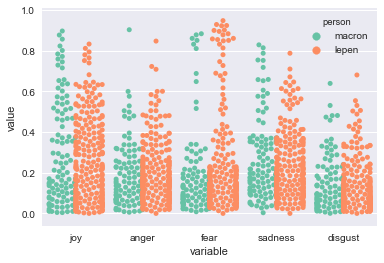

In [49]:
chart = sns.swarmplot(data=full_parsed_melted, x="variable",\
              y="value", hue="person", palette="Set2",split=True)

Hard to tell anything from this swarm plot, which does not account for the difference in sizes of the two series, so we try a more traditional box-and-whiskers plot instead. 

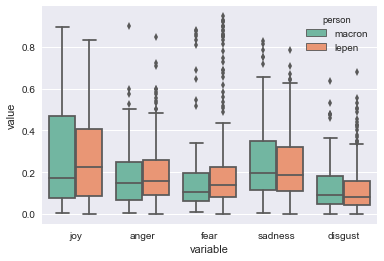

In [50]:
chart = sns.boxplot(data=full_parsed_melted, x="variable",\
              y="value", hue="person", palette="Set2")
#chart = sns.swarmplot(data=full_parsed_melted, x="variable",\
#              y="value", hue="person", palette="Set2",split=True)

Interesting -- From the box-plots it looks like the mean of the emotions are the same across the board, with perhaps the exception of joy. Lots of outliers on fear and disgust. 

I run the **Kolmogorov-Smirnov test** to compare the distributions of the emotion values between Le Pen and Macron. I choose this test because 
* you don't need your data to be normally distributed, 
* you don't have to have the same total number of points in either distributions and 
* the means (average) look pretty close to begin with, and I am interested in the entire distribution on [0,1].

In [41]:
from scipy import stats

def cdf(series):

    ser = pd.Series(series)
    ser = ser.sort_values()
    ser[len(ser)] = ser.iloc[-1]
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser)
    return ser_cdf.plot(drawstyle='steps', label=series.name)
    
#code adapted from https://stackoverflow.com/questions/25577352/plotting-cdf-of-a-pandas-series-in-python

Above, I set up a CDF plot function, cdf(), so we can compare the distributions visually to accompany the results of the KS test. 

In the graphs that follow, I write a function to fix the legends correctly.

In [42]:
#write a function to fix the legend properly: 

def jointplot(macron,lepen):
    macronplot=cdf(macron)
    lepenplot=cdf(lepen)
    plt.legend(["Macron","Le Pen"])
    print(stats.ks_2samp(macron,lepen))

Ks_2sampResult(statistic=0.090902358647757975, pvalue=0.53072149215508768)


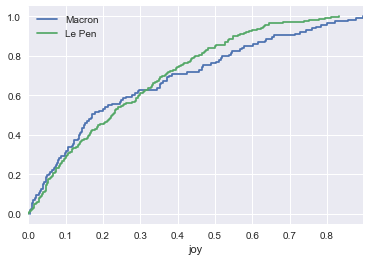

In [43]:
jointplot(macron_parsed.joy,lepen_parsed.joy)

Ks_2sampResult(statistic=0.11178583330247716, pvalue=0.27651099408513186)


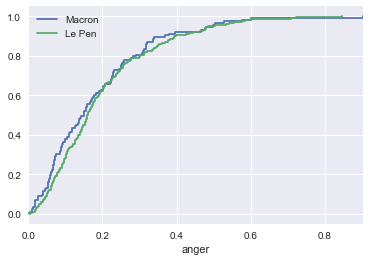

In [44]:
jointplot(macron_parsed.anger,lepen_parsed.anger)

Ks_2sampResult(statistic=0.15714444403302846, pvalue=0.040286278784689836)


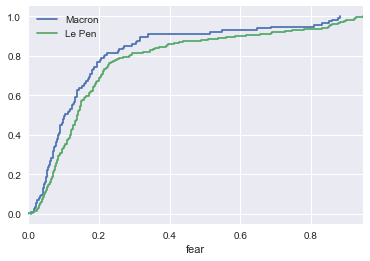

In [45]:
jointplot(macron_parsed.fear,lepen_parsed.fear)

**The above result for the Kolmogorov-Smirnov test is significant at $\alpha$ = 5%.**

Ks_2sampResult(statistic=0.076387603213981525, pvalue=0.74548509529949614)


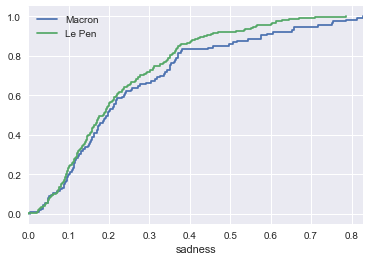

In [46]:
jointplot(macron_parsed.sadness,lepen_parsed.sadness)

Ks_2sampResult(statistic=0.075091642907394451, pvalue=0.76410862573107663)


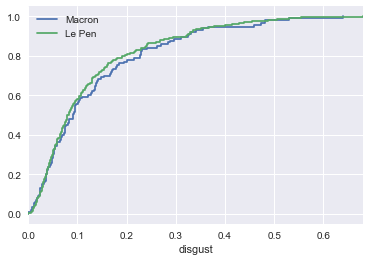

In [47]:
jointplot(macron_parsed.disgust,lepen_parsed.disgust)

Out of the five Kolmogorov-Smirnov tests above, it looks like the distribution of fear for Le Pen and Macron are drawn from different distributions. From the CDF's, we can see that **fear is an emotion that gets invoked more when Le Pen is mentioned**.  With a p-value of 4%, this is statistically significant where $\alpha$ = 5%. 